# Python implementation of efficient edge recording

## Background 

* Forward simulations still have trouble scaling
* I showed how to parallelize simplification, but we are still
  "leaving performance on the table" for the fundamental operations.
* fwdpp has had a more efficient edge buffering method for over two years.
* I presented it at one of the first tskit-dev meetings, but the feeling
  was that it may be too specific (only applying to forward sims).
  * I no longer agree -- the performance benefits are really big
    and this type of sim is a core use for tskit-c.

## Motivation

* I want to move fwdpy11 from using fwdpp's tables to tskit's.
  * Reason: to output, we make a copy from fwdpp tables to tskit tables.
    * In practice, we seem to always use less memory than SLiM, even
      with this extra copy. However, this copying will bite us in the butt at some point
      as simulations get larger and larger (N + total genetic map length).
  * Reason 2: fwdpp has been a good testing ground for new ideas, but I can do
    the same kinda experimentation more easily with my "top secret" [fwdpp replacement](https://github.com/ForwardSimulation/forrustts/)
* We don't want to lose performance.
* The barriers are:
  * Sorting tables...
  
## Recent progress

* Port the fwdpp edge buffer to tskit-rust.
  * This is an open PR.
  * The functionality is feature-gated.
  * This PR gives the `buffering` results in the benchmark plots.
  * Results are good, but arguably not great.
  * Recording API is inelegant due to inner workings of simplification:
    * The edge table validation uses stricter criteria than what 
      the algorithm requires.
    * The buffering API needs to do extra steps to buffer segments by 
      child. In practice, hashing seems the best way to do this, making
      it difficult to port back to C.
    * We also need to bulk copy from the buffer to the tables prior to simplification.
      This copying is unnecessary, inelegant, and hurts performance.
* Stack a PR on top of the one described above.
  * This PR must never be merged into tskit-rust.
  * Add functionality to the C API to allow manual control over the simplification
    steps.
  * These tskit-c changes allow us to avoid all the API ugliness described above.
  * **None of the internal tskit-c simplification machinery gets leaked due to applying the "PIMPL idiom"**
  * This PR gives the `buffering_streaming` benchmark results.
  * Full disclosure: this PR is not fully optimised. 
    It does too much work, has at least one allocation during simplification that can be removed, etc.. 
    Stacking it on the previous PR and then hacking led to some sub-optimal design re:the edge buffers inner workings.
    
### Limitations of the rust prototype

1. As simulation epochs get longer, we retain performance benefits but memory savings are not as good.
   This behavior is due to the capacity doubling behavior of `Vec`.
   It is easy to change this:
   * Allow a `max_capacity_increase` field.
   * Allow capacity doubling until a doubling is a larger than `max_capacity_increase`, at which
     point we rely on [Vec::reserve_exact](https://doc.rust-lang.org/std/vec/struct.Vec.html#method.reserve_exact)
     prior to any calls to `push`.
   * We can play analagos games in `tskit-c` with `realloc`.
   
### Example of running the rust prototype

The following code will run the edge buffer + modular simplification methods.

```sh
gh repo clone tskit-dev/tskit-rust
cd tskit-rust
gh pr checkout 443
cargo build --release --examples --feature edgebuffer
```

Run this script, `run.sh`:
                                           
```sh
#!/bin/sh

ARGS="666 25000 250000 100"

/usr/bin/time -f "%e %M" -o old_nocheck.time ./target/release/examples/haploid_wright_fisher -b $ARGS old.trees &
/usr/bin/time -f "%e %M" -o old_nobookmark.time ./target/release/examples/haploid_wright_fisher $ARGS old_nobookmark.trees &
/usr/bin/time -f "%e %M" -o new_nocheck.time ./target/release/examples/haploid_wright_fisher_edge_buffering $ARGS new.trees                                           
```

When it returns, run `compare.py`:

```python
import tskit

old = tskit.load("old.trees")
old_nobookmark = tskit.load("old_nobookmark.trees")
new = tskit.load("new.trees")

assert old_nobookmark.num_trees == old.num_trees
assert old_nobookmark.num_nodes == old.num_nodes
assert old_nobookmark.num_edges == old.num_edges
assert old.num_trees == new.num_trees
assert old.num_nodes == new.num_nodes
assert old.num_edges == new.num_edges

# We cannot use KC distance because:
# 1. We get OOM error with tree seqs this large.
# 2. Not all of the trees will have exactly 1 root.
for i, j, k in zip(old.trees(), old_nobookmark.tree(), new.trees()):
    assert i.span == j.span
    assert i.total_branch_length == j.total_branch_length
    assert i.span == k.span
    assert i.total_branch_length == k.total_branch_length
```

Pro tip: the Python script takes ages.
The asserts all pass.
    
## The Python prototype

The code below is a Python prototype that does everything except one step that is needed to correctly handle non-overlapping generations.
That step is described in words at the bottom of this notebook.

In [1]:
import tskit
import numpy as np
from IPython.display import SVG

In [2]:
class Segment(object):
    def __init__(self, left, right):
        assert left < right, f"{left} must be < {right}"
        self.left = left
        self.right = right
    
    def __repr__(self):
        return f"Segment({self.left}, {self.right})"
        
class EdgeBuffer(object):
    def __init__(self):
        # Our linked lists managers
        self.head = [] # i-th value records the start of data for parent i.
        self.tail = []
        self.next = []
        # Our data
        self.left = []
        self.right = []
        self.child = []
        # helpers
        self.collected_children = dict()
        self.children = []
        
    def _clear(self):
        """
        Free up memory
        """
        self.head = []
        self.tail = []
        self.next = []
        self.left = []
        self.right = []
        self.child = []
        self.collected_children = dict()
        self.children = []
        
    def _buffer_edge(self, left, right, parent, child):
        if parent >= len(self.head):
            self.head.extend([-1]*(parent-len(self.head)+1))
            self.tail.extend([-1]*(parent-len(self.tail)+1))
            assert parent + 1 == len(self.head), f"{parent}, {len(self.head)}"
            assert parent + 1 == len(self.tail), f"{parent}, {len(self.tail)}"
            
        assert parent < len(self.head), f"{parent} {len(self.head)}"
        assert parent < len(self.tail), f"{parent} {len(self.tail)}"

        if self.head[parent] == -1:
            self._insert_new_parent(left, right, parent, child)
        else:
            self._extend_parent(left, right, parent, child)
            
    def _update_data(self, left, right, child):
        self.left.append(left)
        self.right.append(right)
        self.child.append(child)
        
    def _insert_new_parent(self, left, right, parent, child):
        self._update_data(left, right, child)
        self.head[parent] = len(self.left) - 1
        self.tail[parent] = self.head[parent]
        self.next.append(-1)
    
    def _extend_parent(self, left, right, parent, child):
        self._update_data(left, right, child)
        temp = self.tail[parent]
        self.tail[parent] = len(self.left) - 1
        self.next[temp] = len(self.left) - 1
        self.next.append(-1)
        
    # Can skip right to _buffer_edge w/modular simplification API
    def record_edge(self, left, right, parent, child):
        self.collected_children[parent][child].append(Segment(left, right))
    
    # Not necessary w/modular simplification API
    def init_recording_offspring(self, parents, children):
        self.children = sorted([i for i in set([j for j in children])])
        self.collected_children = dict()
        for p in parents:
            self.collected_children[p] = {c: [] for c in self.children}
    
    # Not necessary w/modular simplification API
    def finalize_recording_offspring(self):
        for p, edges in self.collected_children.items():
            for c in self.children:
                for e in edges[c]:
                    assert e.left < e.right
                    self._buffer_edge(e.left, e.right, p, c)

    # This implementation suffices for non-overlapping
    # generations and for overlapping generations.
    # However, this type is not ready for overlapping
    # generations -- see comments at end of notebook.
    # Notes:
    # * In C, this is done more efficiently by
    #   appending edge tables rows and then
    #   doing a "left rotation" of each column
    #   when done.
    def prep_for_simplification(self, tables):
        left = []
        right = []
        parent = []
        child = []
        
        # NOTE: this sorting exists because simplification can scramble
        # the relationship between node it and birth time for non-overlapping
        # generations.
        # This sort is much less expensive than the current sorting approaches!
        sorted_head_index = sorted([i for i in range(len(self.head)) if self.head[i] != -1],
                             key = lambda x: tables.nodes.time[x])

        # Go backwards in time through new edges
        for parentid in sorted_head_index:
            h = self.head[parentid]
            left.append(self.left[h])
            right.append(self.right[h])
            parent.append(parentid)
            child.append(self.child[h])

            next = self.next[h]
            while next != -1:
                left.append(self.left[next])
                right.append(self.right[next])
                parent.append(parentid)
                child.append(self.child[next])
                next = self.next[next]
                    
        assert len(left) == len(right)
        assert len(left) == len(parent)
        assert len(left) == len(child)

        # Append ancient edges
        left.extend(tables.edges.left.tolist())
        right.extend(tables.edges.right.tolist())
        parent.extend(tables.edges.parent.tolist())
        child.extend(tables.edges.child.tolist())
        
        assert len(left) == len(right)
        assert len(left) == len(parent)
        assert len(left) == len(child)
        
        # Set columns
        tables.edges.set_columns(left=left, right=right,
                                 parent=np.array(parent, dtype=np.int32),
                                 child=np.array(child, dtype=np.int32))
        assert tables.edges.num_rows > 0 # technically a bad idea
        
        # Free memory prior to simplifying
        self._clear()

In [3]:
# Haploid sim w/exactly one crossover per offspring
def overlapping_generations(seed, popsize, nsteps, simplify, pdeath=1.0):
    assert pdeath == 1.0, "The buffer is not generalized to overlapping generations yet"
    assert pdeath > 0.0 and pdeath <= 1.0
    L = 10
    tables = tskit.TableCollection(L)
    buffer = EdgeBuffer()
    birth_time = nsteps
    parents = []
    np.random.seed(seed)
    for _ in range(popsize):
        n = tables.nodes.add_row(0, birth_time)
        parents.append(n)
        
    for t in range(birth_time-1, -1, -1):
        deaths = []
        for i in range(len(parents)):
            if np.random.sample(1) <= pdeath:
                deaths.append(i)
        births = []
        for _ in range(len(deaths)):
            p1 = np.random.choice(parents, 1)[0]
            p2 = np.random.choice(parents, 1)[0]
            c = tables.nodes.add_row(0, t)
            births.append(c)
            breakpoint = np.random.randint(1, L, 1)[0]
            current_parents = [p1, p2]
            children = [c]
            buffer.init_recording_offspring(current_parents, children) # only needed b/c of current tskit requirements
            buffer.record_edge(0, breakpoint, p1, c)
            buffer.record_edge(breakpoint, L, p2, c)
            buffer.finalize_recording_offspring() # only needed b/c of current tskit requirements

        assert len(births) == len(parents)
        for i,d in enumerate(deaths):
            parents[d] = births[i]

        if t % simplify == 0:
            assert all(tables.nodes.time[i] == t for i in parents) # non-overlapping gens only!
            # OMG we are not calling table sort here!!!!
            buffer.prep_for_simplification(tables)
            idmap = tables.simplify(samples=parents)
            for i in range(len(parents)):
                assert idmap[parents[i]] != -1
                parents[i] = idmap[parents[i]]
              
    return tables.tree_sequence()

In [4]:
ts = overlapping_generations(42, 5, 10, 5)

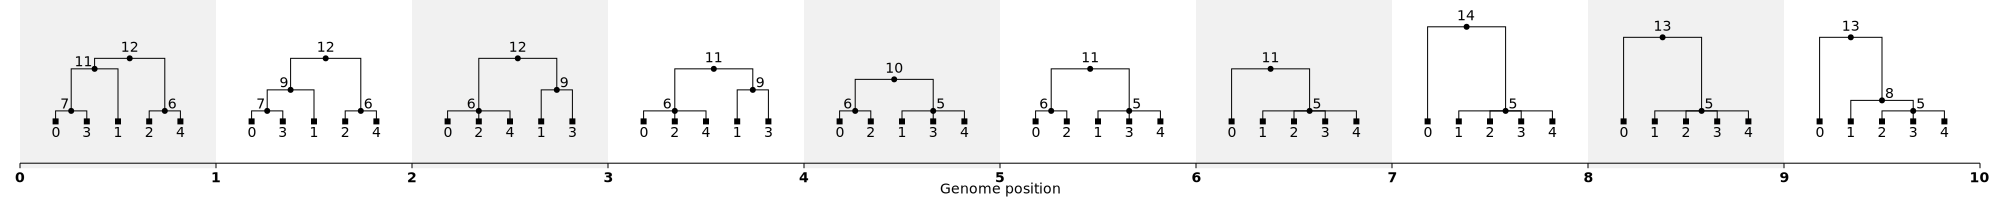

In [5]:
SVG(ts.draw_svg())

# What we really want to do

* Skip the bulk movement of data from edge buffer to edge table.
* Have a simplification API where client code can control the steps.
* This is "power user mode", but the payoff is performance.

Let's look at some pseudocode:

```rust
// We will look at the behind-the-scenes of this next.
let mut simplifier = ModularSimplifier::new(samples, options, &mut tables);

// Process the most recent births
for h in edge_buffer.iter_backwards_in_time() {
    for (left, right, parent, child) in edge_buffer.get_edges(h) {
        // runs "extract ancestry"
        simplifier.enqueue_edge(left, right, parent, child);
    }
    // runs "merge ancestors", resets internal queue size to 0
    simplifier.merge_ancestors();
}

// Process the ancient edges
// simplifier.process_input_edges();
let input_edges = simplifier.input_edge_table_reference();
let mut i = 0;
while i < input_edges.num_rows() {
    let p = input_edges.parent(i);
    while i < input_edges.num_rows() && input_edges.parent(i) == p {
        simplifier.enqueue_edge(left, right, parent, child);
        i += 1;
    }
    simplifier.merge_ancestors();
}

// The final cleanup steps that occur at the end of the current
// simplifier_run() function
simplifier.finalise();
```

For a variety of reasons, the above is not strictly possible. 
(At least not right now.)
However, I do have its functional equivalent working, albeit crudely.

This "modular" simplification allows you to:

* skip collecting newborn edges by child id.
* doing big pointless transfers of big arrays

For overlapping generations, the buffer needs to:

* Be fed the maximum time of nodes live during the last simplification.
* Take this time and go over the edge table, inserting all edges for which `time[parent]` is <= `max_time`.
* Record the last edge index from the last step.
* Left-rotate the columns at this index and truncate the edge table.

These steps must be done at the START of a recording epoch so that your final simplification at the end of a sim doesn't steal edges from the edge table.

## TODO list for PRs

* Extract final simplification steps to new static function. **NOT NECESSARY ANY LONGER--FINALISE CAN HANDLE ALL OF THIS.**
* Implement modular simpifier
  * Tests: we should get same outputs as the regular method.
* Implement `tsk_edge_buffer_t`
  * This would get people to use it.
  * The down side is that most folks will stop there, possibly halting innovations.
  * I think it is important to not just implement this w/o a public "modular simplifier".
    * There may be other clever uses of fine-grained control over simplification steps.
* Document and/or example program.